# Spark Collaborative Filtering (ALS) Deep Dive

Spark MLlib provides a collaborative filtering algorithm that can be used for training a matrix factorization model, which predicts explicit or implicit ratings of users on items for recommendations.

This notebook presents a deep dive into the Spark collaborative filtering algorithm.

## 0 Global settings


In [1]:
# set the environment path to find Recommenders
import sys
sys.path.append("../../")
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import sys
import pandas as pd
import pyspark
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col
from pyspark.ml.tuning import CrossValidator

from reco_utils.common.spark_utils import start_or_get_spark
from reco_utils.evaluation.spark_evaluation import SparkRankingEvaluation, SparkRatingEvaluation
from reco_utils.evaluation.parameter_sweep import generate_param_grid
from reco_utils.dataset.url_utils import maybe_download
from reco_utils.dataset.spark_splitters import spark_random_split

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("PySpark version: {}".format(pyspark.__version__))

System version: 3.6.0 | packaged by conda-forge | (default, Feb  9 2017, 14:36:55) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
Pandas version: 0.23.4
PySpark version: 2.3.1


Data URL and path

In [2]:
DATA_URL = "http://files.grouplens.org/datasets/movielens/ml-100k/u.data"


Data column names

In [3]:
COL_USER = "userID"
COL_ITEM = "itemID"
COL_RATING = "rating"
COL_PREDICTION = "prediction"
COL_TIMESTAMP = "timestamp"

HEADER = {
    "col_user": COL_USER,
    "col_item": COL_ITEM,
    "col_rating": COL_RATING,
    "col_prediction": COL_PREDICTION,
}

Model hyper parameters

In [4]:
RANK = 10
MAX_ITER = 5
REG_PARAM = 0.01

Number of recommended items

In [5]:
K = 10

## 1 Matrix factorization algorithm

### 1.1 Matrix factorization for collaborative filtering problem

Matrix factorization is a common technique used in recommendation tasks. Basically, a matrix factorization algorithm tries to find latent factors that represent intrinsic user and item attributes in a lower dimension. That is,

$$\hat r_{u,i} = q_{i}^{T}p_{u}$$

where $\hat r_{u,i}$ is the predicted ratings for user $u$ and item $i$, and $q_{i}^{T}$ and $p_{u}$ are latent factors for item and user, respectively. The challenge to the matrix factorization problem is to find $q_{i}^{T}$ and $p_{u}$. This is achieved by methods such as matrix decomposition. A learning approach is therefore developed to converge the decomposition results close to the observed ratings as much as possible. Furthermore, to avoid overfitting issue, the learning process is regularized. For example, a basic form of such matrix factorization algorithm is represented as below.

$$\min\sum(r_{u,i} - q_{i}^{T}p_{u})^2 + \lambda(||q_{i}||^2 + ||p_{u}||^2)$$

where $\lambda$ is a the regularization parameter. 

In case explict ratings are not available, implicit ratings which are usually derived from users' historical interactions with the items (e.g., clicks, views, purchases, etc.). To account for such implicit ratings, the original matrix factorization algorithm can be formulated as 

$$\min\sum c_{u,i}(p_{u,i} - q_{i}^{T}p_{u})^2 + \lambda(||q_{i}||^2 + ||p_{u}||^2)$$

where $c_{u,i}=1+\alpha r_{u,i}$ and $p_{u,i}=1$ if $r_{u,i}>0$ and $p_{u,i}=0$ if $r_{u,i}=0$. $r_{u,i}$ is a numerical representation of users' preferences (e.g., number of clicks, etc.). 

### 1.2 Alternating Least Square (ALS)

Owing to the term of $q_{i}^{T}p_{u}$ the loss function is non-convex. Gradient descent method can be applied but this will incur expensive computations. An Alternating Least Square (ALS) algorithm was therefore developed to overcome this issue. 

The basic idea of ALS is to learn one of $q$ and $p$ at a time for optimization while keeping the other as constant. This makes the objective at each iteration convex and solvable. The alternating between $q$ and $p$ stops when there is convergence to the optimal. It is worth noting that this iterative computation can be parallelised and/or distributed, which makes the algorithm desirable for use cases where the dataset is large and thus the user-item rating matrix is super sparse (as is typical in recommendation scenarios). A comprehensive discussion of ALS and its distributed computation can be found [here](http://stanford.edu/~rezab/classes/cme323/S15/notes/lec14.pdf).

## 2 Spark Mllib implementation

The matrix factorization algorithm is available as `ALS` module in [Spark `ml`](https://spark.apache.org/docs/latest/ml-collaborative-filtering.html) for DataFrame or [Spark `mllib`](https://spark.apache.org/docs/latest/mllib-collaborative-filtering.html) for RDD. 

* The uniqueness of ALS implementation is that it distributes the matrix factorization model training by using "Alternating Least Square" method. 
* In the training method, there are parameters that can be selected to control the model performance.
* Both explicit and implicit ratings are supported by Spark ALS model.

## 3 Spark ALS based Movielens recommender

In the following code, the Movielens-100K dataset is used to illustrate the ALS algorithm in Spark.

First, a Spark session is initialized.

In [6]:
spark = start_or_get_spark("Spark ALS", "local")

### 3.1 Load and prepare data

Data is read from csv into a Spark DataFrame.

In [7]:
# read small file over HTTP
dfs = spark.createDataFrame(pd.read_csv(DATA_URL, delimiter = "\t", header = None))\
.withColumnRenamed("0", COL_USER).withColumnRenamed("1", COL_ITEM) \
.withColumnRenamed("2", COL_RATING) \
.withColumnRenamed("3", COL_TIMESTAMP)

In [8]:
dfs.show(5)

+------+------+------+---------+
|userID|itemID|rating|timestamp|
+------+------+------+---------+
|   196|   242|     3|881250949|
|   186|   302|     3|891717742|
|    22|   377|     1|878887116|
|   244|    51|     2|880606923|
|   166|   346|     1|886397596|
+------+------+------+---------+
only showing top 5 rows



Data is then randomly split by 80-20 ratio for training and testing.

In [9]:
dfs_train, dfs_test = spark_random_split(dfs, ratio=0.8)

In [10]:
dfs_train = dfs_train.select(COL_USER, COL_ITEM, COL_RATING)
dfs_test = dfs_test.select(COL_USER, COL_ITEM, COL_RATING).withColumn(COL_RATING, col(COL_RATING).cast("float"))

### 3.2 Train a movielens model 

It is worth noting that Spark ALS model allows dropping cold users to favor a robust evaluation with the testing data. In case there are cold users, Spark ALS implementation allows users to drop cold users in order to make sure evaluations on the prediction results are sound.

In [11]:
als = ALS(
    maxIter=MAX_ITER, 
    rank=RANK,
    regParam=REG_PARAM, 
    userCol=COL_USER, 
    itemCol=COL_ITEM, 
    ratingCol=COL_RATING, 
    coldStartStrategy="drop"
)

model = als.fit(dfs_train)

### 3.3 Prediction with the model

The trained model can be used to predict ratings with a given test data.

In [12]:
dfs_pred = model.transform(dfs_test).drop(COL_RATING)

With the prediction results, the model performance can be evaluated.

In [13]:
evaluations = SparkRatingEvaluation(
    dfs_test, 
    dfs_pred,
    col_user=COL_USER,
    col_item=COL_ITEM,
    col_rating=COL_RATING,
    col_prediction=COL_PREDICTION
)

print(
    "RMSE score = {}".format(evaluations.rmse()),
    "MAE score = {}".format(evaluations.mae()),
    "R2 score = {}".format(evaluations.rsquared()),
    "Explained variance score = {}".format(evaluations.exp_var()),
    sep="\n"
)

RMSE score = 1.0547933259454159
MAE score = 0.8077588428909183
R2 score = 0.10889909064450953
Explained variance score = 0.11037302785291736


Oftentimes ranking metrics are also of interest to data scientists.

In [14]:
evaluations = SparkRankingEvaluation(
    dfs_test, 
    dfs_pred,
    col_user=COL_USER,
    col_item=COL_ITEM,
    col_rating=COL_RATING,
    col_prediction=COL_PREDICTION,
    k=K
)

print(
    "Precision@k = {}".format(evaluations.precision_at_k()),
    "Recall@k = {}".format(evaluations.recall_at_k()),
    "NDCG@k = {}".format(evaluations.ndcg_at_k()),
    "Mean average precision = {}".format(evaluations.map_at_k()),
    sep="\n"
)

Precision@k = 0.8260084925690018
Recall@k = 0.6764684468941833
NDCG@k = 0.9998855741459399
Mean average precision = 0.6764684468941833


### 3.4 Fine tune the model

Prediction performance of a Spark ALS model is often affected by the parameters

|Parameter|Description|Default value|Notes|
|-------------|-----------------|------------------|-----------------|
|`rank`|Number of latent factors|10|The larger the more intrinsic factors considered in the factorization modeling.|
|`regParam`|Regularization parameter|1.0|The value needs to be selected empirically to avoid overfitting.|
|`maxIters`|Maximum number of iterations|10|The more iterations the better the model converges to the optimal point.|

It is always a good practice to start model building with default parameter values and then sweep the parameter in a range to find the optimal combination of parameters. The following parameter set is used for training ALS models for comparison study purposes.

In [15]:
param_dict = {
    "rank": [10, 15, 20, 25],
    "regParam": [0.001, 0.1, 1.0]
}

Generate a dictionary for each parameter combination which can then be fed into model training.

In [16]:
param_grid = generate_param_grid(param_dict)

Train models with parameters specified in the parameter grid. Evaluate the model with, for example, the RMSE metric, and then record the metrics for visualization.

In [17]:
rmse_score = []

for g in param_grid:
    als = ALS(        
        userCol=COL_USER, 
        itemCol=COL_ITEM, 
        ratingCol=COL_RATING, 
        coldStartStrategy="drop",
        **g
    )
    
    model = als.fit(dfs_train)
    
    dfs_pred = model.transform(dfs_test).drop(COL_RATING)
    
    evaluations = SparkRatingEvaluation(
        dfs_test, 
        dfs_pred,
        col_user=COL_USER,
        col_item=COL_ITEM,
        col_rating=COL_RATING,
        col_prediction=COL_PREDICTION
    )

    rmse_score.append(evaluations.rmse())

rmse_score = [float('%.4f' % x) for x in rmse_score]
rmse_score_array = np.reshape(rmse_score, (len(param_dict["rank"]), len(param_dict["regParam"]))) 

In [18]:
rmse_df = pd.DataFrame(data=rmse_score_array, index=pd.Index(param_dict["rank"], name="rank"), 
                       columns=pd.Index(param_dict["regParam"], name="reg. parameter"))

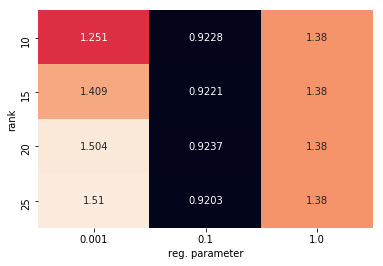

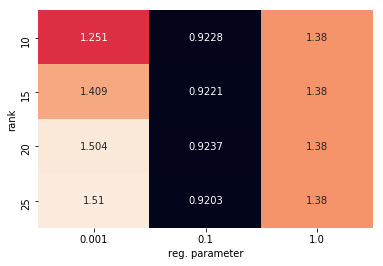

In [19]:
fig, ax = plt.subplots()
sns.heatmap(rmse_df, cbar=False, annot=True, fmt=".4g")
display(fig)

The calculated RMSE scores can be visualized to comparatively study how model performance is affected by different parameters.

It can be seen from this visualization that RMSE first decreases and then increases as rank increases, due to overfitting. When the rank equals 20 and the regularization parameter equals 0.1, the model achieves the lowest RMSE score.

It is noted from the visualization that the RMSE does not decrease together with increase of `rank`, which may be owing to the reason of overfitting. When `rank` is 10 and `regParam` is 0.1, the lowest RMSE score is achieved, which indicates that the model is optimal.

### 3.5 Top K recommendation

#### 3.5.1 Top k for all users (items)

In [20]:
dfs_rec = model.recommendForAllUsers(10)

In [21]:
dfs_rec.show(10)

+------+--------------------+
|userID|     recommendations|
+------+--------------------+
|   471|[[814, 3.3796077]...|
|   463|[[814, 3.1276855]...|
|   833|[[814, 3.2469037]...|
|   496|[[814, 3.131886],...|
|   148|[[814, 4.046012],...|
|   540|[[814, 3.9868734]...|
|   392|[[814, 4.173561],...|
|   243|[[814, 3.7596216]...|
|   623|[[814, 3.8591926]...|
|   737|[[814, 3.9317896]...|
+------+--------------------+
only showing top 10 rows



#### 3.5.2 Top k for a selected set of users (items)

In [22]:
users = dfs_train.select(als.getUserCol()).distinct().limit(3)

dfs_rec_subset = model.recommendForUserSubset(users, 10)

In [23]:
dfs_rec_subset.show(10)

+------+--------------------+
|userID|     recommendations|
+------+--------------------+
|    26|[[814, 3.183741],...|
|   474|[[814, 4.2062182]...|
|    29|[[814, 3.898106],...|
+------+--------------------+



#### 3.5.3 Run-time considerations for top-k recommendations

It is worth noting that usually computing the top-k recommendations for all users is the bottleneck of the whole pipeline (model training and scoring) of an ALS based recommendation system. This is because
* Getting the top k from all user-item pairs requires a cross join which is usually very computationally expensive. 
* Inner products of user-item pairs are calculated individually instead of leveraging matrix block multiplication features which are available in certain contemporary computing acceleration libraries (e.g., BLAS).

More details about possible optimizations of the top k recommendations in Spark can be found [here](https://engineeringblog.yelp.com/2018/05/scaling-collaborative-filtering-with-pyspark.html).

## References

1. Yehuda Koren, Robert Bell, and Chris Volinsky, "Matrix Factorization Techniques for Recommender Systems
", ACM Computer, Vol. 42, Issue 8, pp 30-37, Aug., 2009.
2. Yifan Hu, Yehuda Koren, and Chris Volinsky, "Collaborative Filtering for Implicit Feedback Datasets
", Proc. IEEE ICDM, 2008, Dec, Pisa, Italy.
3. Apache Spark. url: https://spark.apache.org/docs/latest/ml-collaborative-filtering.html
4. Seaborn. url: https://seaborn.pydata.org/
5. Scaling collaborative filtering with PySpark. url: https://engineeringblog.yelp.com/2018/05/scaling-collaborative-filtering-with-pyspark.html
6. Matrix Completion via Alternating Least Square (ALS). url: http://stanford.edu/~rezab/classes/cme323/S15/notes/lec14.pdf